In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import cv2
import random
import shutil
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

print("\nProje için tüm kütüphaneler başarıyla import edildi.")

/kaggle/input/test-resmim/indir (1).png
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv

Proje için tüm kütüphaneler başarıyla import edildi.


In [8]:
# Hasar efekti fonksiyonlarını tanımla

def apply_wrinkle_effect(image):
    rows, cols, _ = image.shape
    x_map, y_map = np.zeros((rows, cols), np.float32), np.zeros((rows, cols), np.float32)
    frequency, amplitude = np.random.uniform(5, 10), np.random.uniform(10, 20)
    for i in range(rows):
        for j in range(cols):
            x_map[i, j] = j + amplitude * np.cos(2 * np.pi * i / (rows / frequency))
            y_map[i, j] = i + amplitude * np.sin(2 * np.pi * j / (cols / frequency))
    return cv2.remap(image, x_map, y_map, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def apply_stain_effect(image):
    stained_image = image.copy()
    rows, cols, _ = image.shape
    center_x, center_y = np.random.randint(0, cols), np.random.randint(0, rows)
    radius = np.random.randint(int(cols/10), int(cols/4))
    color, alpha = (33, 67, 101), 0.4 # BGR formatında kahverengi ve şeffaflık
    overlay = stained_image.copy()
    cv2.circle(overlay, (center_x, center_y), radius, color, -1)
    cv2.addWeighted(overlay, alpha, stained_image, 1 - alpha, 0, stained_image)
    return stained_image

def apply_tear_effect(image):
    torn_image = image.copy()
    rows, cols, _ = image.shape
    tear_x, tear_y = np.random.randint(int(cols/4), int(cols/2)), np.random.randint(int(rows/4), int(rows/2))
    corner = np.random.randint(0, 4)
    if corner == 0: pts = np.array([[0, 0], [tear_x, 0], [0, tear_y]], np.int32)
    elif corner == 1: pts = np.array([[cols, 0], [cols - tear_x, 0], [cols, tear_y]], np.int32)
    elif corner == 2: pts = np.array([[0, rows], [0, rows - tear_y], [tear_x, rows]], np.int32)
    else: pts = np.array([[cols, rows], [cols - tear_x, rows], [cols, rows - tear_y]], np.int32)
    cv2.fillPoly(torn_image, [pts], (0, 0, 0))
    return torn_image

print("Özel veri artırma fonksiyonları tanımlandı.")

Özel veri artırma fonksiyonları tanımlandı.


In [9]:
# Zip dosyasını aç ve küçük veri setini üret

# Adım 1: Zip Dosyasını Aç
print("Zip dosyası açılıyor...")
zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_path = '/kaggle/working/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("-> Zip dosyası açıldı.")

# Adım 2: Küçük Veri Setini Üret (Proof-of-Concept)
print("Küçük veri seti üretiliyor...")
start_time = time.time()
source_dir = '/kaggle/working/train/'
base_dir = '/kaggle/working/dataset/'
saglam_dir = os.path.join(base_dir, 'saglam')
hasarli_dir = os.path.join(base_dir, 'hasarli')
os.makedirs(saglam_dir, exist_ok=True)
os.makedirs(hasarli_dir, exist_ok=True)
all_images = os.listdir(source_dir)
random.shuffle(all_images)
num_samples = 200 # Küçük set ile test
for img_name in all_images[:num_samples]: shutil.copyfile(os.path.join(source_dir, img_name), os.path.join(saglam_dir, img_name))
efektler = [apply_wrinkle_effect, apply_stain_effect, apply_tear_effect]
for img_name in all_images[num_samples:num_samples*2]:
    original_image = cv2.imread(os.path.join(source_dir, img_name))
    if original_image is not None:
        secilen_efekt = random.choice(efektler)
        hasarli_image = secilen_efekt(original_image)
        cv2.imwrite(os.path.join(hasarli_dir, 'hasarli_' + img_name), hasarli_image)
end_time = time.time()
print(f"-> Veri seti üretimi tamamlandı! Süre: {end_time - start_time:.2f} saniye.")

Zip dosyası açılıyor...
-> Zip dosyası açıldı.
Küçük veri seti üretiliyor...
-> Veri seti üretimi tamamlandı! Süre: 30.81 saniye.


Veri, model için hazırlanıyor...
Found 639 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
-> Veri jeneratörleri hazır.

Model mimarisi kuruluyor ve eğitim başlatılıyor...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.4828 - loss: 0.8903 - val_accuracy: 0.6013 - val_loss: 0.6912
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6055 - loss: 0.6759 - val_accuracy: 0.5886 - val_loss: 0.6617
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6715 - loss: 0.5924 - val_accuracy: 0.5443 - val_loss: 0.6770
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6823 - loss: 0.5381 - val_accuracy: 0.6266 - val_loss: 0.6708
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6963 - loss: 0.5417 - val_accuracy: 0.6013 - val_loss: 0.7069
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7235 - loss: 0.5022 - val_accuracy: 0.6076 - val_loss: 0.8870
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7490 - loss: 0.4325 - val_accuracy: 0.5949 - val_loss: 0.7508
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8071 - loss: 0.4017 - val_accuracy: 0.5759 -

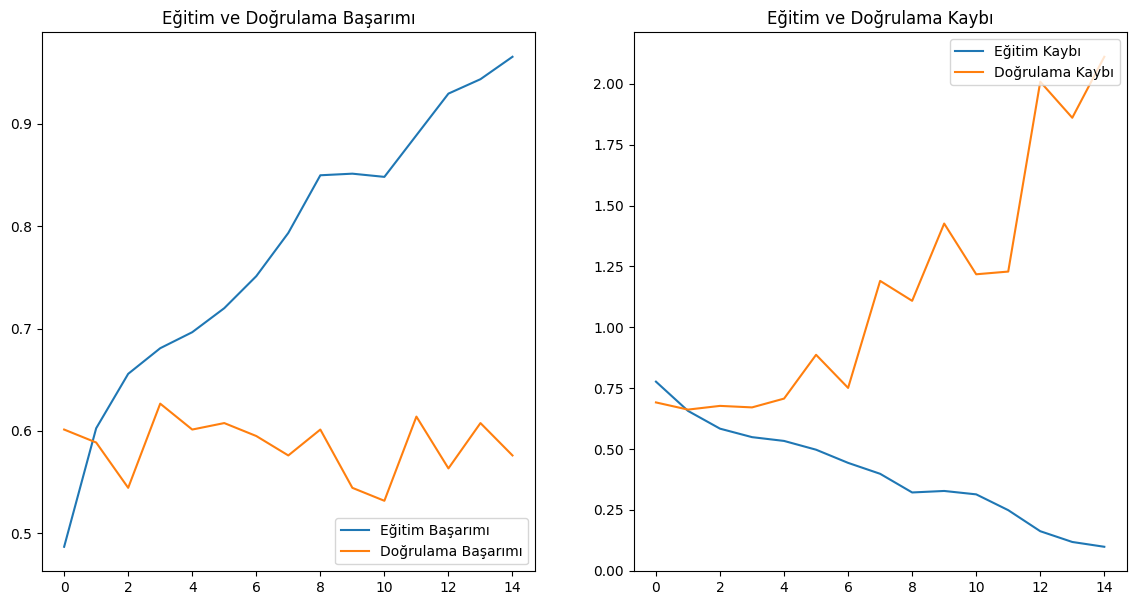

In [10]:
# Veriyi Hazırla, Modeli Kur, Eğit ve Sonuçları Göster

# Adım 1: Veriyi Modele Hazırla
print("Veri, model için hazırlanıyor...")
IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE = 150, 150, 32
base_dir = '/kaggle/working/dataset/'
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = image_generator.flow_from_directory(directory=base_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='training')
validation_generator = image_generator.flow_from_directory(directory=base_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='validation')
print("-> Veri jeneratörleri hazır.")

# Adım 2: Modeli Oluştur ve Eğit
print("\nModel mimarisi kuruluyor ve eğitim başlatılıyor...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Flatten(), Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
epochs = 15
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
print("\n--- EĞİTİM BAŞARIYLA TAMAMLANDI! ---")

# Adım 3: Eğitim Sonuçlarını Görselleştir
print("\nEğitim performans grafikleri çiziliyor...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Başarımı')
plt.plot(epochs_range, val_acc, label='Doğrulama Başarımı')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

Test için seçilen resim: /kaggle/working/dataset/hasarli/hasarli_dog.9443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Tahmin: HASARLI (Skor: 0.17)


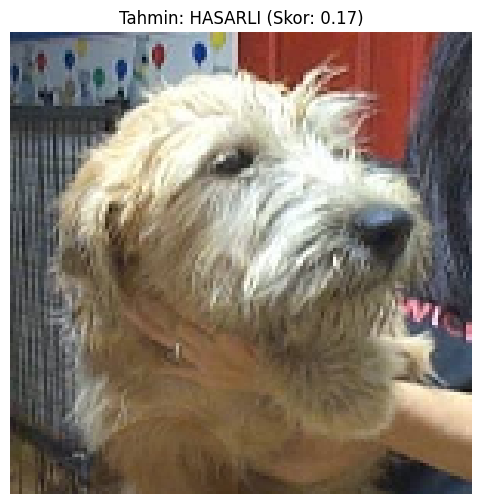

In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Test için 'hasarli' veya 'saglam' klasörünü seçebilirsin
test_klasoru = hasarli_dir 
rastgele_resim = random.choice(os.listdir(test_klasoru))
resim_yolu = os.path.join(test_klasoru, rastgele_resim)

print(f"Test için seçilen resim: {resim_yolu}")

# Resmi modele uygun boyuta getir ve yükle
img = image.load_img(resim_yolu, target_size=(IMG_WIDTH, IMG_HEIGHT))

# Resmi bir sayı dizisine çevir
img_array = image.img_to_array(img)
# Piksel değerlerini 0-1 arasına ölçeklendir
img_array /= 255.0
# Modele tek bir resim göndereceğimizi belirtmek için boyut ekle
img_array = np.expand_dims(img_array, axis=0)

# TAHMİN YAP
tahmin = model.predict(img_array)

if tahmin[0][0] < 0.5:
    sonuc = f"Tahmin: HASARLI (Skor: {tahmin[0][0]:.2f})"
else:
    sonuc = f"Tahmin: SAĞLAM (Skor: {tahmin[0][0]:.2f})"

print(sonuc)

# Sonucu görselleştir
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(sonuc)
plt.axis('off')
plt.show()

Test için seçilen resim: /kaggle/input/test-resmim/indir (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tahmin: SAĞLAM (Skor: 0.59)


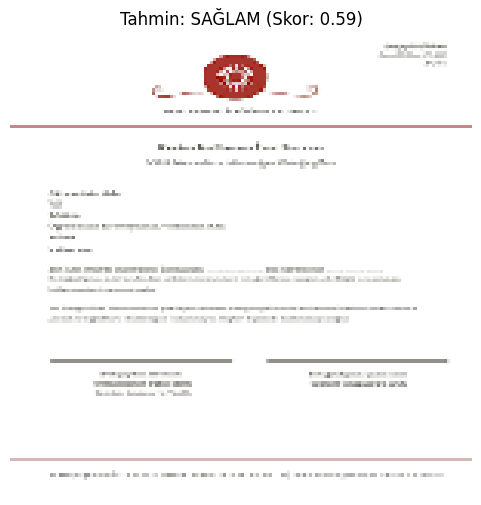

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


resim_yolu = '/kaggle/input/test-resmim/indir (1).png' 

print(f"Test için seçilen resim: {resim_yolu}")



img = image.load_img(resim_yolu, target_size=(IMG_WIDTH, IMG_HEIGHT))
img_array = image.img_to_array(img)
img_array /= 255.0
img_array = np.expand_dims(img_array, axis=0)

tahmin = model.predict(img_array)

if tahmin[0][0] < 0.5:
    sonuc = f"Tahmin: HASARLI (Skor: {tahmin[0][0]:.2f})"
else:
    sonuc = f"Tahmin: SAĞLAM (Skor: {tahmin[0][0]:.2f})"

print(sonuc)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(sonuc)
plt.axis('off')
plt.show()